## MiniProject for LLM course

### Requirements

In [ ]:
!pip install os
!pip install pandas
!pip install dotenv
!pip install random
!pip install openai
!pip install langchain_core
!pip install langchain_ollama
!pip install re
!pip install json
!pip install numpy
!pip install sklearn
!pip install matplotlib

In [32]:
import pandas as pd 
import random
import os 
from dotenv import load_dotenv
from openai import OpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import json
import ollama
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

In [34]:
# Load OPENAI API KEY present in the .env file
load_dotenv(".env")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [35]:
def read_xl_wic_file(file_path):
    """
    Reads XL-WiC format txt file and converts to DataFrame.
    Format: target_word \t PoS \t start_idx1 \t end_idx1 \t start_idx2 \t end_idx2 \t example1 \t example2 \t label

    The files follow a tab-separated format:
    target_word <tab> PoS <tab> start-char-index_1 <tab> end-char-index_1 <tab> start-char-index_2 <tab> end-char-index_2 <tab> example_1 <tab> example_2 <tab> label

    - "target_word": the target word which is present in both examples.
    - "PoS": the Part-of-Speech tag of the target word (either "N": noun or "V": verb).
    - "start-index_i": indicates the start char index of target_word in "i"th example. 
    - "end-index_i": indicates the end char index of target_word in "i"th example. 
    - "example_i": corresponds to the "i"th example.
    - "label": can be 1 or 0 depending on whether the intended sense of the target word is the same in both examples (1) or not (0).
    """
    columns = [
        'target_word', 'pos', 
        'start_idx1', 'end_idx1', 
        'start_idx2', 'end_idx2',
        'example1', 'example2', 
        'label'
    ]
    
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            row = [item.strip() for item in line.split('\t')]
            if len(row) == len(columns):
                # Convert indices and label to integers
                row[2:6] = [int(x) for x in row[2:6]]  # Convert all indices
                row[-1] = int(row[-1])  # Convert label
                data.append(row)
    
    return pd.DataFrame(data, columns=columns)

df = read_xl_wic_file('/home/max/Desktop/UNI_Bielefeld/LLM/xlwic_wn_xlingual/xlwic_wn_xlingual/train_en.txt')

In [36]:
def sample_xl_wic_pairs(df, n_samples=100, seed=42):
    """
    Samples random word pairs from XL-WiC dataset and formats them for LLM evaluation
    """
    n_samples_per_label = n_samples // 2
    if seed:
        random.seed(seed)
        np.random.seed(seed)

    # Ensure balanced sampling for each label
    balanced_samples = []
    for label in df['label'].unique():
        label_samples = df[df['label'] == label].sample(n=n_samples_per_label, random_state=seed)
        balanced_samples.append(label_samples)
    combined_samples = pd.concat(balanced_samples).sample(frac=1, random_state=seed)

    formatted_samples = []
    for _, row in combined_samples.iterrows():
        sample_dict = {
            'word': row['target_word'],
            'pos': 'Noun' if row['pos'] == 'N' else 'Verb',
            'sentence1': row['example1'],
            'sentence2': row['example2'],
            'true_label': row['label'],
            'meaning': 'same' if row['label'] == 1 else 'different'
        }
        formatted_samples.append(sample_dict)

    return formatted_samples

In [37]:
# eval with OPENAI models
def evaluate_with_llm_OPENAI(samples, model, template):
    client = OpenAI()
    results = []

    for sample in samples:
        prompt = f"Sentence 1: {sample['sentence1']}\nSentence 2: {sample['sentence2']}"
        
        completion = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": template},
                {"role": "user", "content": prompt}
            ]
        )
        
        llm_response = completion.choices[0].message.content
        pred_label = None

        try:
            pred = llm_response.split('Label:')[-1][:3]
            if '1' in pred:	
                pred_label = 1
            elif '0' in pred:
                pred_label = 0 
            else:
                print('trouble finding label')
                print(llm_response)
            results.append({
                'word': sample['word'],
                'true_label': sample['true_label'],
                'pred_label': pred_label,
                'llm_response': llm_response
            })
        except:
            print('Error in prediction')
            print(llm_response)  

    return results

# eval with ollama models (llama3.3, phi3)
def evaluate_with_ollama(samples, Model, Template, template_id = 0):
    class agent():
        def __init__(self, role, model=Model):
            self.role = role
            self.model = model
        def generate(self, prompt):
            return ollama.generate(prompt=prompt, system=self.role, model=self.model, stream=False)["response"]
        
    customized_agent = agent(role=Template, model=Model)
    results = []
    
    for sample in tqdm(samples, desc=f"Prompting LLM: {Model} Template: {template_id}", smoothing=0):
        #print(f"Processing word: {sample['word']}")
        question = f"target word: {sample['word']}\nSentence 1: {sample['sentence1']}\nSentence 2: {sample['sentence2']}"
        response = customized_agent.generate(question)
        pred_label = None
        try:
            pred = response.split('Label:')[-1][:3]
            if '1' in pred:	
                pred_label = 1
            elif '0' in pred:
                pred_label = 0 
            else:
                print('trouble finding label')
                print(response)      
            results.append({
                'word': sample['word'],
                'true_label': sample['true_label'],
                'pred_label': pred_label,
                'llm_response': response,
                
            })
        except:
            print('Error in prediction')
            print(response)    
    
    return results

In [38]:
samples = sample_xl_wic_pairs(df)
MODEL_GPT3_5_TURBO = "gpt-3.5-turbo-0125"
MODEL_GPT4 = "gpt-4"
MODEL_GPT4_TURBO = "gpt-4-turbo"
MODEL_LLAMA3_2 = "llama3.2:3b"
MODEL_PHI3 = "phi3:latest"
TEMPLATE_V0 = "You are a helpful assistant. My goal is to check if a target word in a sentence has the same intended sense in another sentence. A target word and two sentences will be passed. Check if the intended sense is the same or not. Label as (1) if the meaning is the same, viceversa (0) for different meaning. In the final response you always add a line where you write the correct Label you think it is, starting in the following way: Label."
TEMPLATE_V1 = "You are a linguistics expert. Determine if a given 'target word' has a same meaning in two sentences. Respond with 1 if the meaning of the word is similar or 0 if it is too different. Include your explanation then write in new line 'Label: 1 or '\n" 

In [ ]:
## Results are already saved in json files uncomment to run again

# results_llama_0 = evaluate_with_ollama(samples, MODEL_LLAMA3_2 ,TEMPLATE_V0, template_id=0)
# json.dump(results_llama_0, open('JSON data/llama3-2_template0.json', 'w'), indent=4)
# results_llama_1 = evaluate_with_ollama(samples, MODEL_LLAMA3_2, TEMPLATE_V1, template_id=1)
# json.dump(results_llama_1, open('JSON data/llama3-2_template1.json', 'w'), indent=4)

# results_phi_0 = evaluate_with_ollama(samples, MODEL_PHI3, TEMPLATE_V0, template_id=0)
# json.dump(results_phi_0, open('JSON data/phi3_template0.json', 'w'), indent=4)
# results_phi_1 = evaluate_with_ollama(samples, MODEL_PHI3, TEMPLATE_V1, template_id=1)
# json.dump(results_phi_1, open('JSON data/phi3_template1.json', 'w'), indent=4)

# result_gpt3_5_turbo_template_v0 = evaluate_with_llm_OPENAI(samples, MODEL_GPT3_5_TURBO, TEMPLATE_V0)
# json.dump(result_gpt3_5_turbo_template_v0, open('JSON data/result_gpt3_5_turbo_template_v0.json', 'w'), indent=4)
# result_gpt3_5_turbo_template_v1 = evaluate_with_llm_OPENAI(samples, MODEL_GPT3_5_TURBO, TEMPLATE_V1)
# json.dump(result_gpt3_5_turbo_template_v1, open('JSON data/result_gpt3_5_turbo_template_v1.json', 'w'), indent=4)

# result_gpt4_template_v0 = evaluate_with_llm_OPENAI(samples, MODEL_GPT4, TEMPLATE_V0)
# json.dump(result_gpt4_template_v0, open('JSON data/result_gpt4_template_v0.json', 'w'), indent=4)
# result_gpt4_template_v1 = evaluate_with_llm_OPENAI(samples, MODEL_GPT4, TEMPLATE_V1)
# json.dump(result_gpt4_template_v1, open('JSON data/result_gpt4_template_v1.json', 'w'), indent=4)

# result_gpt4_turbo_template_v0 = evaluate_with_llm_OPENAI(samples, MODEL_GPT4_TURBO, TEMPLATE_V0)
# json.dump(result_gpt4_turbo_template_v0, open('JSON data/result_gpt4_turbo_template_v0.json', 'w'), indent=4)
# result_gpt4_turbo_template_v1 = evaluate_with_llm_OPENAI(samples, MODEL_GPT4_TURBO, TEMPLATE_V1)
# json.dump(result_gpt4_turbo_template_v1, open('JSON data/result_gpt4_turbo_template_v1.json', 'w'), indent=4)

In [39]:
def evaluate_models(true_labels, predictions1, predictions2, template1_name="Template 0", template2_name="Template 1"):
    def calculate_metrics(true_labels, predictions):
        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions)
        recall = recall_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions)
        return accuracy, precision, recall, f1

    metrics1 = calculate_metrics(true_labels, predictions1)
    metrics2 = calculate_metrics(true_labels, predictions2)

    cm1 = confusion_matrix(true_labels, predictions1)
    cm2 = confusion_matrix(true_labels, predictions2)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=["Different", "Same"], yticklabels=["Different", "Same"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix: {template1_name}")
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", xticklabels=["Different", "Same"], yticklabels=["Different", "Same"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix: {template2_name}")
    
    plt.tight_layout()
    plt.show()

    metrics_labels = ["Accuracy", "Precision", "Recall", "F1 Score"]
    metrics_values = np.array([metrics1, metrics2])
    
    x = np.arange(len(metrics_labels))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, metrics_values[0], width, label=template1_name, color="skyblue")
    plt.bar(x + width/2, metrics_values[1], width, label=template2_name, color="salmon")
    plt.xticks(x, metrics_labels)
    plt.ylabel("Score")
    plt.title("Model Evaluation Metrics Comparison")
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"{template1_name} Metrics:")
    print(f"  Accuracy: {metrics1[0]:.2f}, Precision: {metrics1[1]:.2f}, Recall: {metrics1[2]:.2f}, F1 Score: {metrics1[3]:.2f}")
    print(f"{template2_name} Metrics:")
    print(f"  Accuracy: {metrics2[0]:.2f}, Precision: {metrics2[1]:.2f}, Recall: {metrics2[2]:.2f}, F1 Score: {metrics2[3]:.2f}")

    return metrics1, metrics2

In [70]:
results_l_0 = json.load(open('JSON data/llama3-2_template0.json'))
results_l_1 = json.load(open('JSON data/llama3-2_template1.json'))
results_p_0 = json.load(open('JSON data/phi3_template0.json'))
results_p_1 = json.load(open('JSON data/phi3_template1.json'))
results_gpt_3_5_v0 = json.load(open('JSON data/result_gpt3_5_turbo_template_v0.json'))
results_gpt_3_5_v1 = json.load(open('JSON data/result_gpt3_5_turbo_template_v1.json'))
results_gpt_4_v0 = json.load(open('JSON data/result_gpt4_template_v0.json'))
results_gpt_4_v1 = json.load(open('JSON data/result_gpt4_template_v1.json'))
results_gpt_4_turbo_v0 = json.load(open('JSON data/result_gpt4_turbo_template_v0.json'))
results_gpt_4_turbo_v1 = json.load(open('JSON data/result_gpt4_turbo_template_v0.json'))

true_labels = [r['true_label'] for r in results_l_0]
predictions_l_0 = [r['pred_label'] for r in results_l_0]
predictions_l_1 = [r['pred_label'] for r in results_l_1]
predictions_p_0 = [r['pred_label'] for r in results_p_0]
predictions_p_1 = [r['pred_label'] for r in results_p_1]
predictions_gpt_3_5_v0 = [r['pred_label'] for r in results_gpt_3_5_v0]
predictions_gpt_3_5_v1 = [r['pred_label'] for r in results_gpt_3_5_v1]
predictions_gpt_4_v0 = [r['pred_label'] for r in results_gpt_4_v0]
predictions_gpt_4_v1 = [r['pred_label'] for r in results_gpt_4_v1]
predictions_gpt_4_turbo_v0 = [r['pred_label'] for r in results_gpt_4_turbo_v0]
predictions_gpt_4_turbo_v1 = [r['pred_label'] for r in results_gpt_4_turbo_v1]

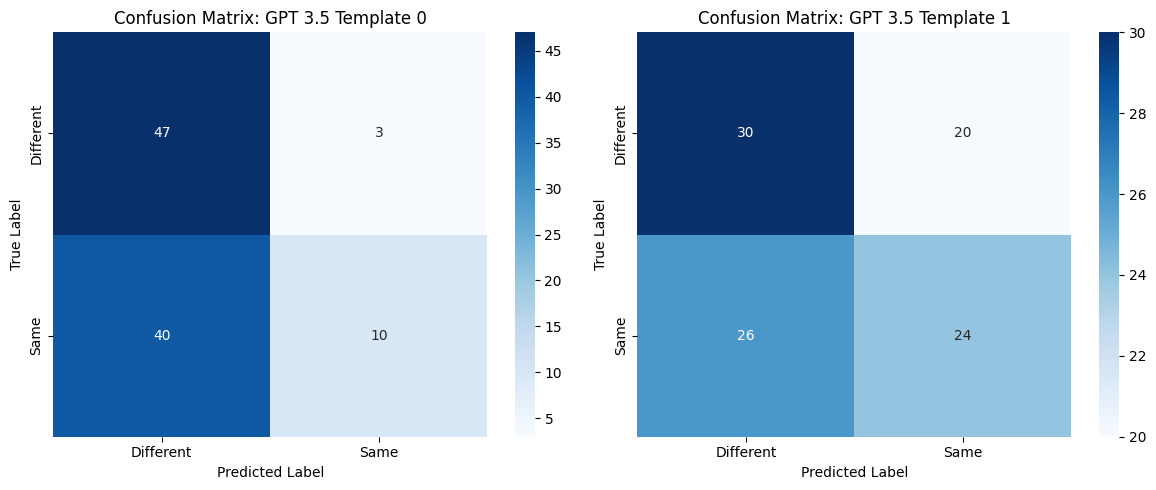

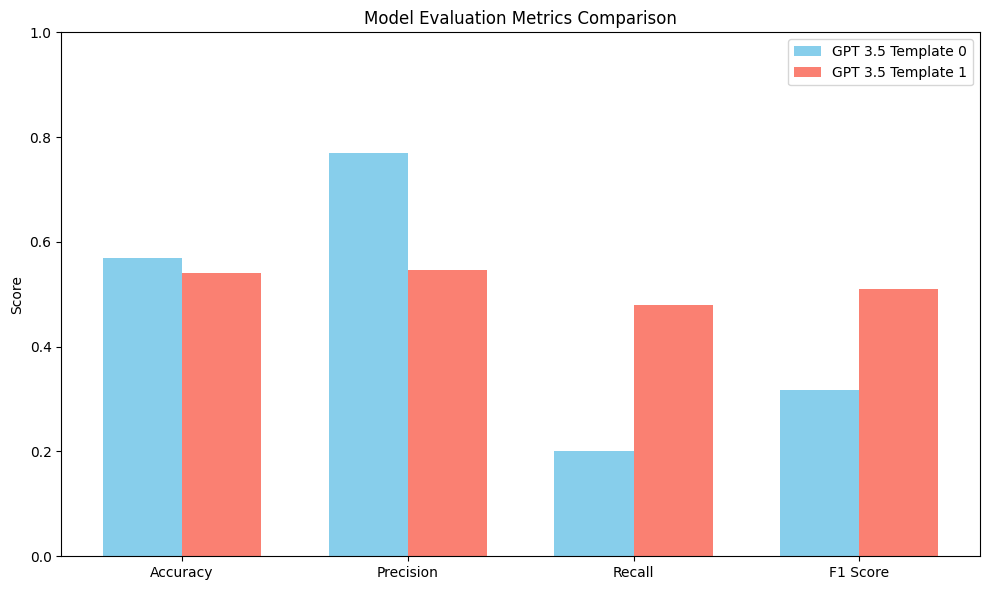

GPT 3.5 Template 0 Metrics:
  Accuracy: 0.57, Precision: 0.77, Recall: 0.20, F1 Score: 0.32
GPT 3.5 Template 1 Metrics:
  Accuracy: 0.54, Precision: 0.55, Recall: 0.48, F1 Score: 0.51


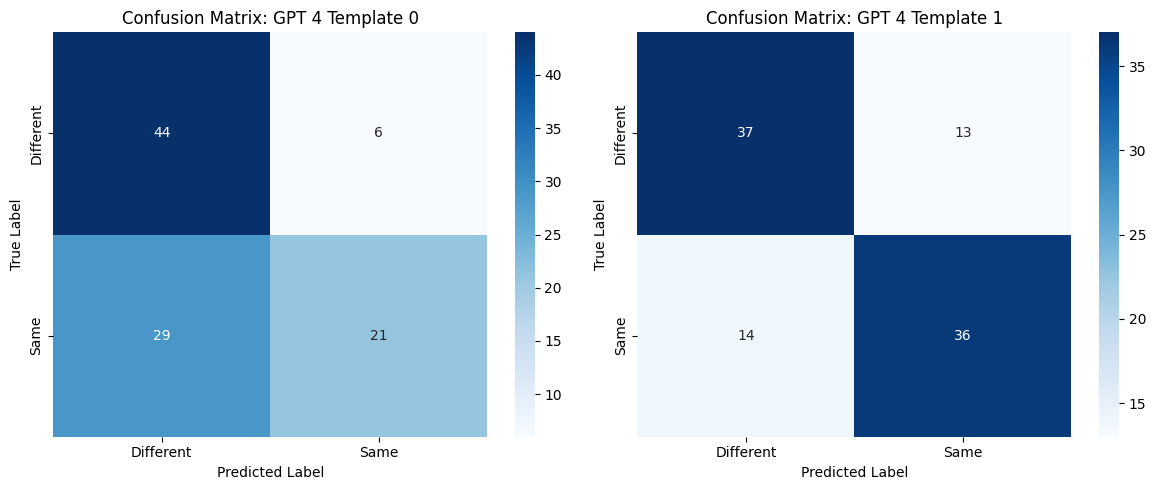

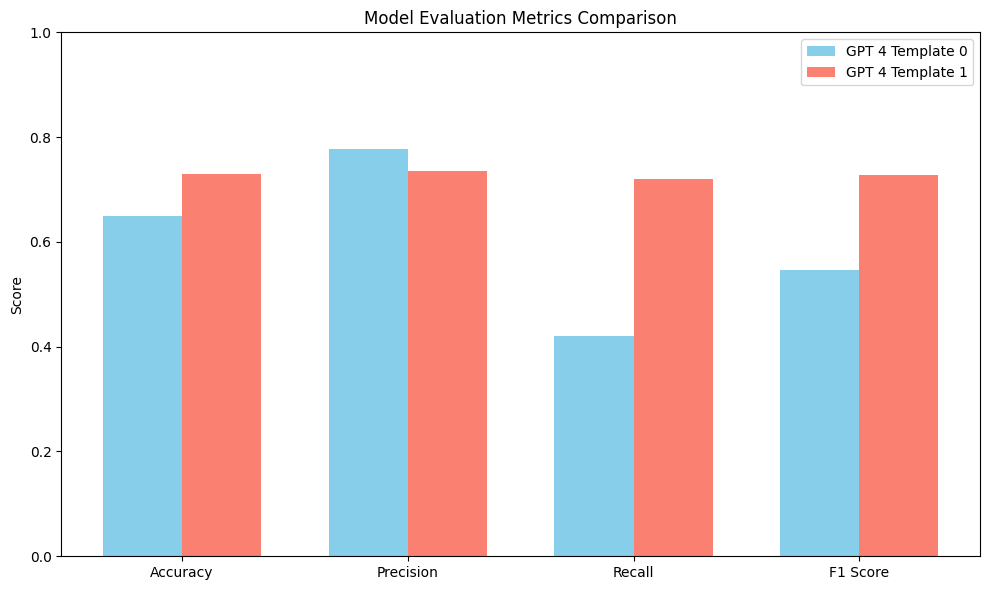

GPT 4 Template 0 Metrics:
  Accuracy: 0.65, Precision: 0.78, Recall: 0.42, F1 Score: 0.55
GPT 4 Template 1 Metrics:
  Accuracy: 0.73, Precision: 0.73, Recall: 0.72, F1 Score: 0.73


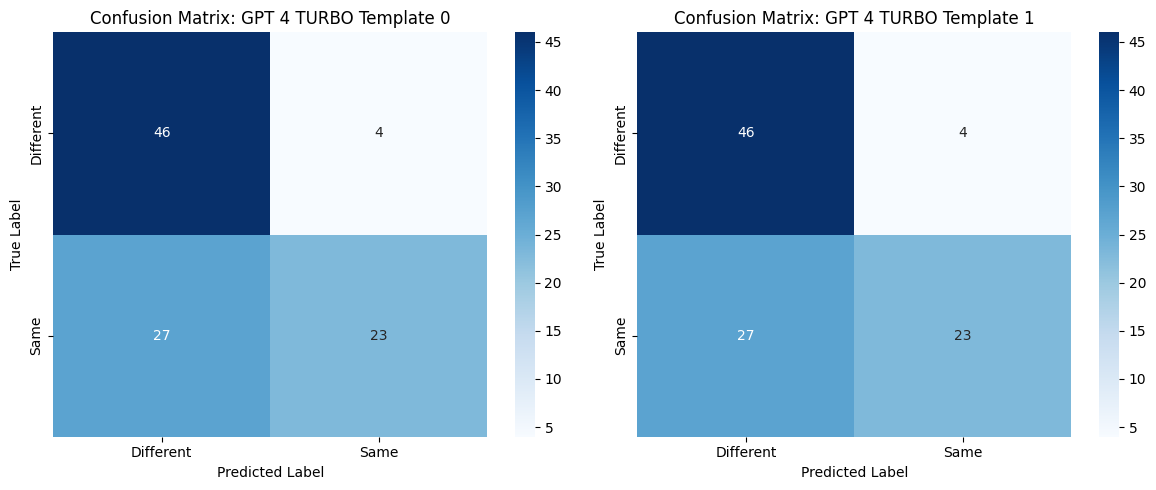

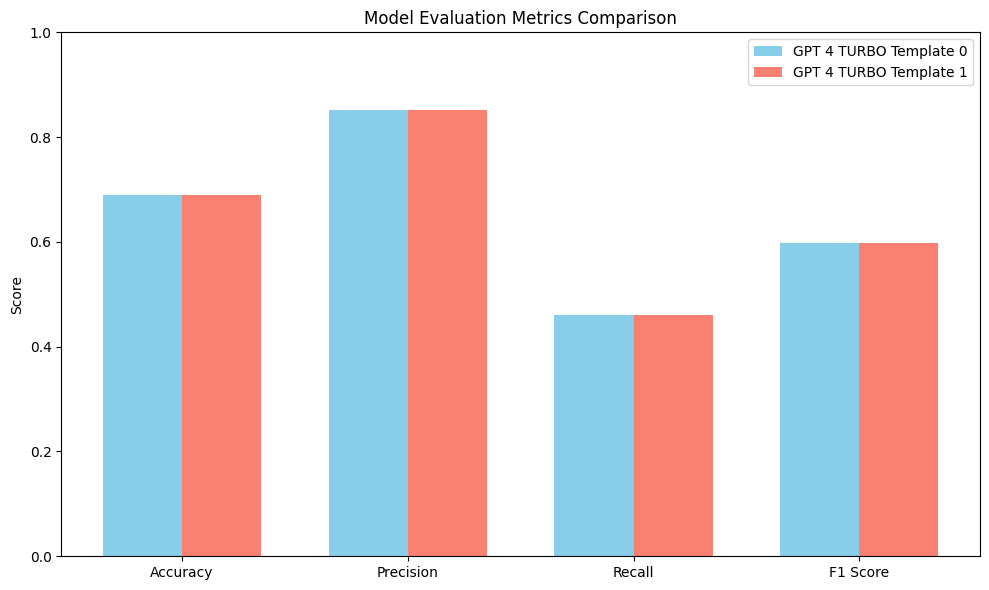

GPT 4 TURBO Template 0 Metrics:
  Accuracy: 0.69, Precision: 0.85, Recall: 0.46, F1 Score: 0.60
GPT 4 TURBO Template 1 Metrics:
  Accuracy: 0.69, Precision: 0.85, Recall: 0.46, F1 Score: 0.60


((0.69, 0.8518518518518519, 0.46, 0.5974025974025974),
 (0.69, 0.8518518518518519, 0.46, 0.5974025974025974))

In [ ]:
evaluate_models(true_labels, predictions_l_0, predictions_l_1, template1_name="LLAMA 3.2 Template 0", template2_name="LLAMA 3.2 Template 1")
evaluate_models(true_labels, predictions_p_0, predictions_p_1, template1_name="Phi 3 Template 0", template2_name="Phi 3 Template 1")
evaluate_models(true_labels, predictions_gpt_3_5_v0, predictions_gpt_3_5_v1, template1_name="GPT 3.5 Template 0", template2_name="GPT 3.5 Template 1")
evaluate_models(true_labels, predictions_gpt_4_v0, predictions_gpt_4_v1, template1_name="GPT 4 Template 0", template2_name="GPT 4 Template 1")
evaluate_models(true_labels, predictions_gpt_4_turbo_v0, predictions_gpt_4_turbo_v1, template1_name="GPT 4 TURBO Template 0", template2_name="GPT 4 TURBO Template 1")

## Playing with embeddings

In [58]:
def get_embeddings_for_probing(samples):
    client = OpenAI()
    embeddings_data = []
    
    for sample in samples:
        # get embeddings for each sentence using text-embedding-ada-002
        sentence1_embedding = client.embeddings.create(
            input=sample['sentence1'],
            model="text-embedding-ada-002"
        ).data[0].embedding
        
        sentence2_embedding = client.embeddings.create(
            input=sample['sentence2'],
            model="text-embedding-ada-002"
        ).data[0].embedding
        
        embeddings_data.append({
            'word': sample['word'],
            'embeddings': (sentence1_embedding, sentence2_embedding),
            'label': sample['true_label']   
        })
    
    return embeddings_data

def get_embeddings_for_probing_ollama(samples, Model="llama3.2"):
    embeddings_data = []

    for sample in  tqdm(samples, desc=f"get Embedding: {Model}", smoothing=0):
        print(f"Processing word: {sample['word']}")
        sentence1_embedding = ollama.embeddings(model=Model, prompt=sample['sentence1'])["embedding"]
        sentence2_embedding = ollama.embeddings(model=Model, prompt=sample['sentence2'])["embedding"]
        embeddings_data.append({
            'word': sample['word'],
            'embeddings': (sentence1_embedding, sentence2_embedding),
            'label': sample['true_label']   
        })
    return embeddings_data    

In [ ]:
# Save embeddings in json file for further analysis
llama_embeddings_data = get_embeddings_for_probing_ollama(samples, Model="llama3.2:3b")
json.dump(llama_embeddings_data, open('JSON data/llama3-2_embeddings_data.json', 'w'), indent=4)

phi_embeddings_data = get_embeddings_for_probing_ollama(samples, Model="phi3:latest")
json.dump(phi_embeddings_data, open('JSON data/phi3_embeddings_data.json', 'w'), indent=4)

# For GPTs we go to use the same embeddings model, so it doesn't matter which version of gpt we are working with. It is different for Phi3 and Llama. 
gpt_embeddings_data = get_embeddings_for_probing(samples)
json_embeddings = json.dump(gpt_embeddings_data, open('JSON data/gpt_embeddings_data.json', 'w'), indent=4)

In [ ]:
phi_embeddings_data = json.load(open('JSON data/phi3_embeddings_data.json'))
llama_embeddings_data = json.load(open('JSON data/llama3-2_embeddings_data.json'))
gpt_embeddings_data = json.load(open('JSON data/gpt_embeddings_data.json'))

In [61]:
def visualize_word_embeddings_2d(embeddings_data, num_samples=5):
    X = np.array([np.concatenate(sample['embeddings']) for sample in embeddings_data])[:num_samples]
    labels = np.array([sample['label'] for sample in embeddings_data])
    words = np.array([sample['word'] for sample in embeddings_data])
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(12, 8))    
    for i in range(len(X_pca)):
        circle = plt.Circle((X_pca[i, 0], X_pca[i, 1]), 
                          radius=10,  # Adjust radius as needed
                          color='red' if labels[i] == 1 else 'blue',
                          alpha=0.2)
        plt.gca().add_patch(circle)
        plt.annotate(words[i], 
                    (X_pca[i, 0], X_pca[i, 1]),
                    fontsize=10,
                    ha='center',
                    va='center')
    
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    plt.title('2D Word Sense Embedding Space')
    
    legend_elements = [Line2D([0], [0], marker='o', color='w',
                            markerfacecolor='red', markersize=10,
                            label='Same Sense'),
                      Line2D([0], [0], marker='o', color='w',
                            markerfacecolor='blue', markersize=10,
                            label='Different Sense')]
    plt.legend(handles=legend_elements)
    plt.gca().set_aspect('equal')
    plt.margins(0.2)
    plt.tight_layout()
    
    return pca, plt.gcf()

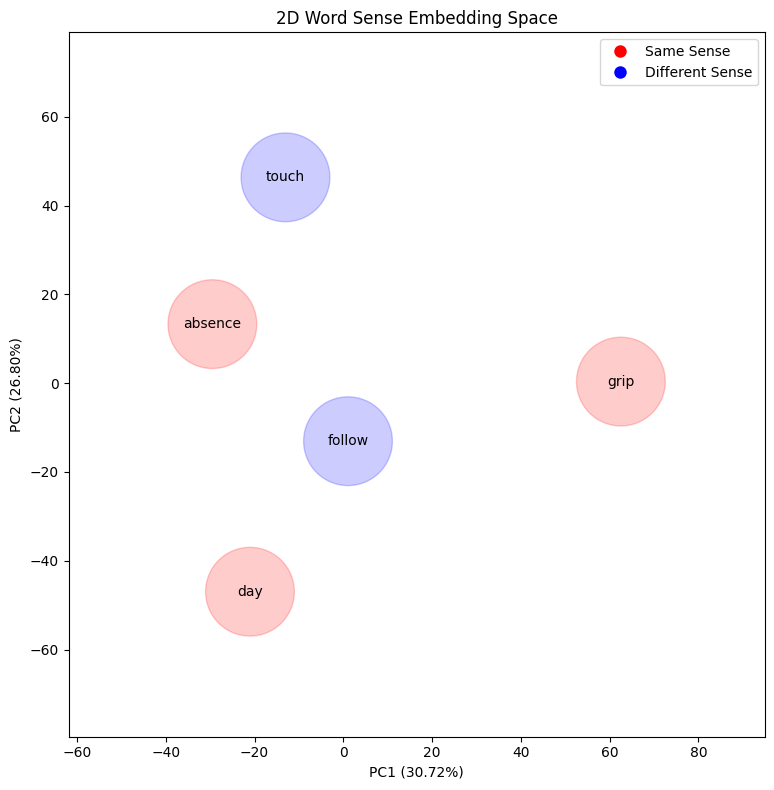

In [62]:
pca_model, fig = visualize_word_embeddings_2d(llama_embeddings_data) # done for 5 samples
plt.show()

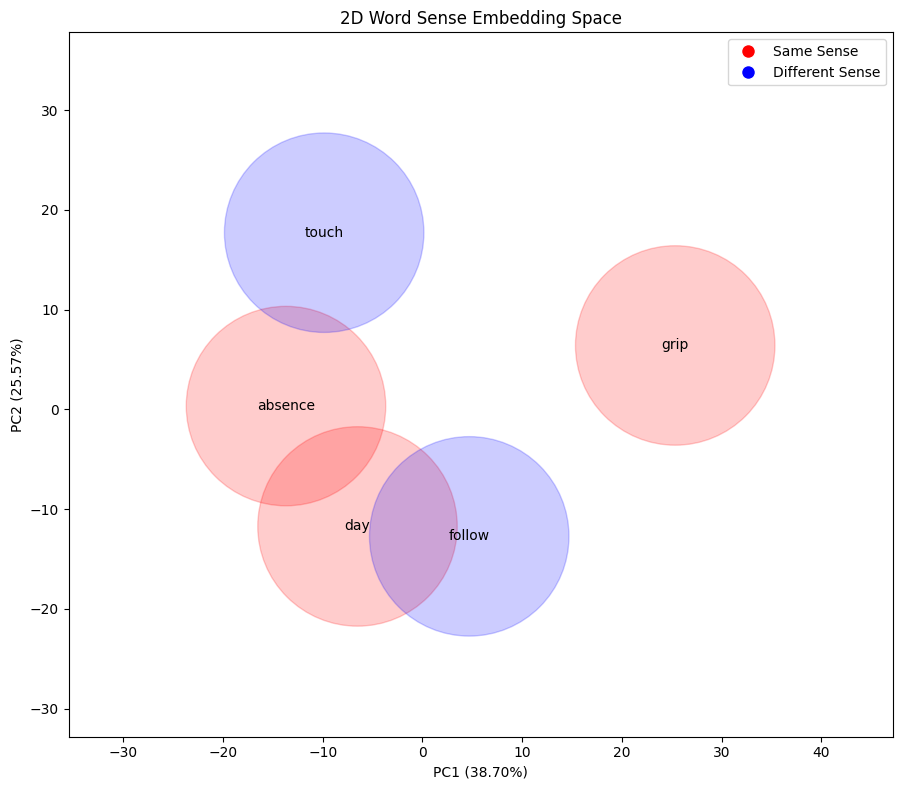

In [63]:
pca_model, fig = visualize_word_embeddings_2d(phi_embeddings_data) # done for 5 samples
plt.show()

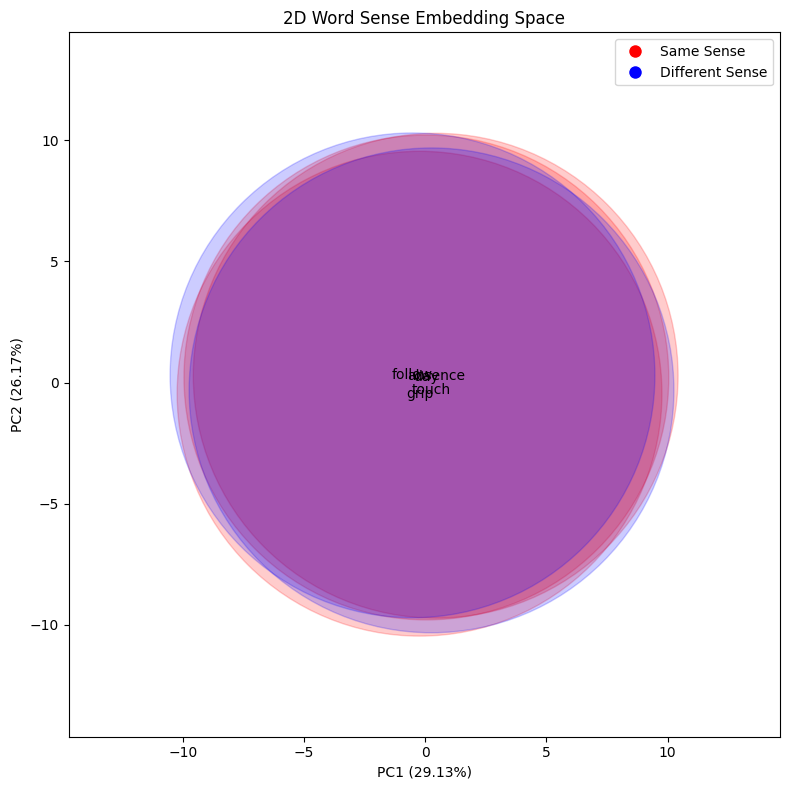

In [64]:
pca_model, fig = visualize_word_embeddings_2d(gpt_embeddings_data) # done for 5 samples
plt.show()

In [ ]:
def visualize_sentence_embeddings_comparison(embeddings_data, title_embeddings, num_samples=5):
    embeddings_data = embeddings_data[:num_samples]
    sentences1_embeddings = np.array([sample['embeddings'][0] for sample in embeddings_data])
    sentences2_embeddings = np.array([sample['embeddings'][1] for sample in embeddings_data])
    labels = np.array([sample['label'] for sample in embeddings_data])
    words = np.array([sample['word'] for sample in embeddings_data])
    all_embeddings = np.vstack([sentences1_embeddings, sentences2_embeddings])
    
    pca = PCA(n_components=3)
    all_embeddings_pca = pca.fit_transform(all_embeddings)
    
    n_samples = len(embeddings_data)
    sent1_pca = all_embeddings_pca[:n_samples]
    sent2_pca = all_embeddings_pca[n_samples:]
    
    fig = plt.figure(figsize=(20, 5))
    views = [(30, 45), (30, 135), (30, 225), (30, 315)]
    
    for idx, (elev, azim) in enumerate(views, 1):
        ax = fig.add_subplot(1, len(views), idx, projection='3d')
        
        for i in range(n_samples):
            ax.plot([sent1_pca[i, 0], sent2_pca[i, 0]],
                   [sent1_pca[i, 1], sent2_pca[i, 1]],
                   [sent1_pca[i, 2], sent2_pca[i, 2]],
                   color='red' if labels[i] == 1 else 'blue',
                   alpha=0.5,
                   linestyle='--')
            
            ax.scatter(sent1_pca[i, 0], sent1_pca[i, 1], sent1_pca[i, 2],
                      color='red' if labels[i] == 1 else 'blue',
                      marker='o')
            ax.scatter(sent2_pca[i, 0], sent2_pca[i, 1], sent2_pca[i, 2],
                      color='red' if labels[i] == 1 else 'blue',
                      marker='^')
            ax.text(sent1_pca[i, 0], sent1_pca[i, 1], sent1_pca[i, 2],
                   f'{words[i]}_1', fontsize=8)
            ax.text(sent2_pca[i, 0], sent2_pca[i, 1], sent2_pca[i, 2],
                   f'{words[i]}_2', fontsize=8)
        
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        ax.view_init(elev=elev, azim=azim)
        ax.set_title(f'View from {elev}°, {azim}°')
        
    plt.suptitle(f'Sentence Embeddings Comparison with {title_embeddings}\nRed: Same Sense, Blue: Different Sense')
    plt.tight_layout()
    
    # legend
    handles = [
        plt.Line2D([0], [0], color='red', label='Same Sense'),
        plt.Line2D([0], [0], color='blue', label='Different Sense'),
        plt.Line2D([0], [0], marker='o', color='gray', label='Sentence 1', linestyle='None'),
        plt.Line2D([0], [0], marker='^', color='gray', label='Sentence 2', linestyle='None')
    ]
    fig.legend(handles=handles, loc='center right')
    
    return pca, fig

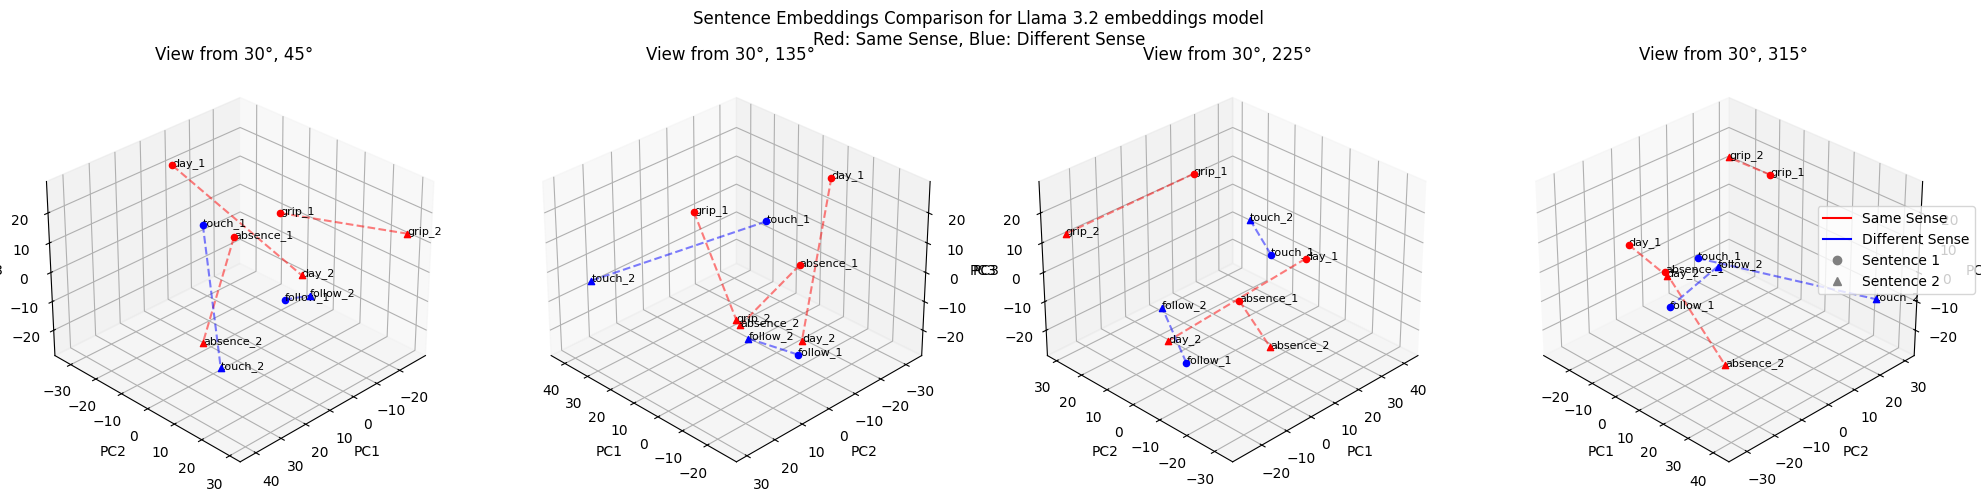

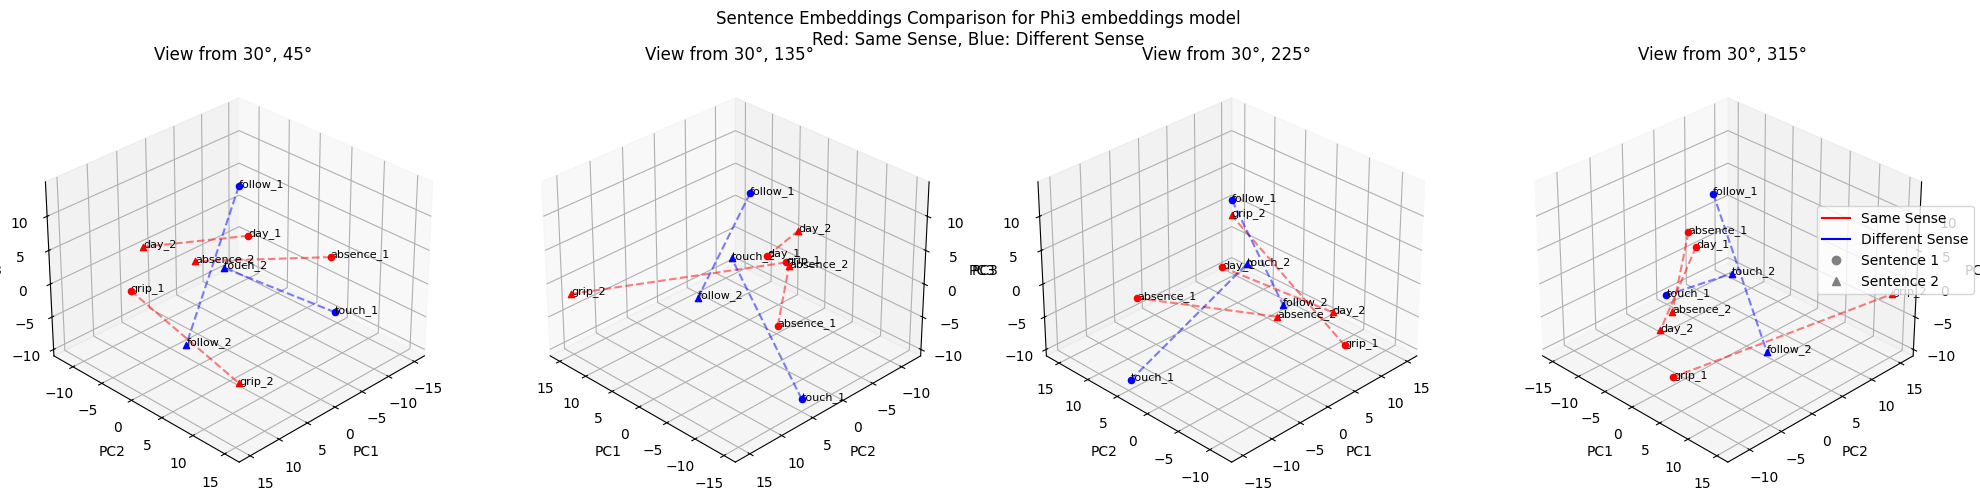

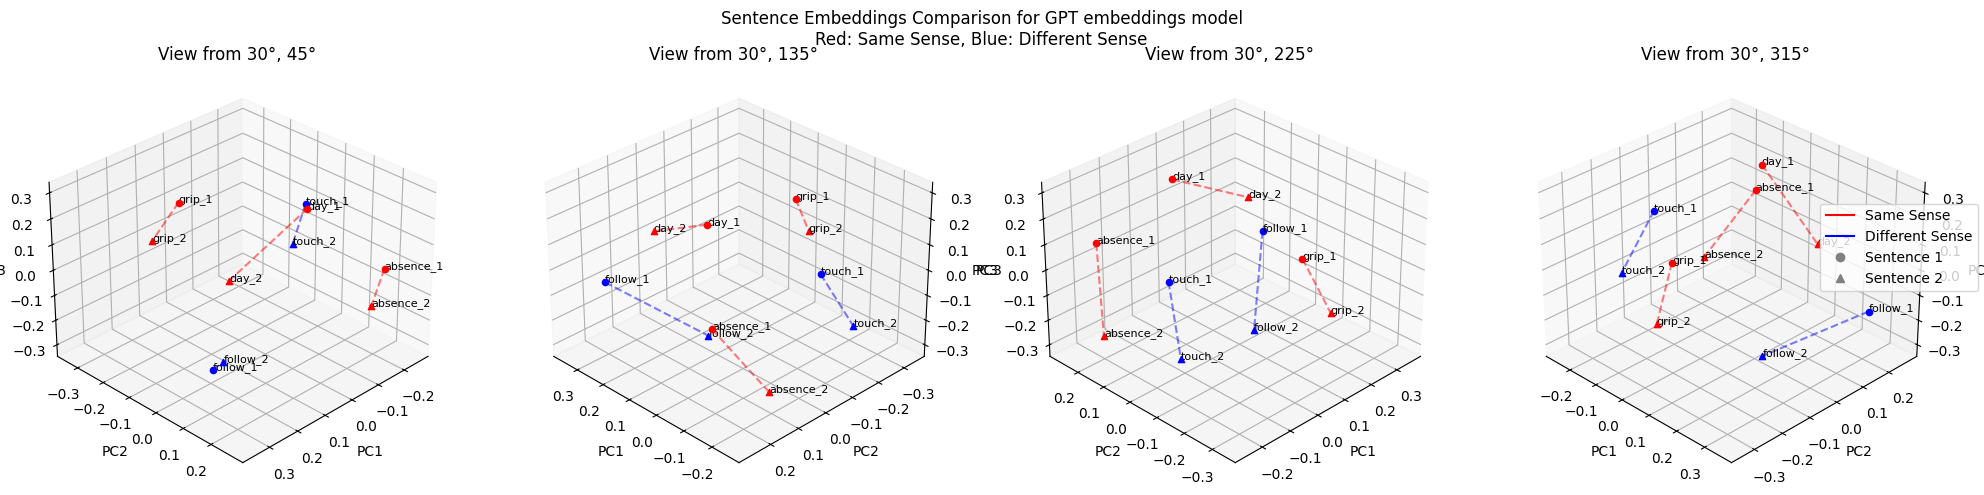

In [61]:
pca_model_sentences, fig_sentences = visualize_sentence_embeddings_comparison(llama_embeddings_data, "Llama 3.2 embeddings model")
pca_model_sentences, fig_sentences = visualize_sentence_embeddings_comparison(phi_embeddings_data, "Phi3 embeddings model")
pca_model_sentences, fig_sentences = visualize_sentence_embeddings_comparison(gpt_embeddings_data, "GPT embeddings model")
plt.show()

In [63]:
def analyze_sense_clusters(embeddings_data):   
    all_embeddings = np.vstack([emb for sample in embeddings_data 
                               for emb in sample['embeddings']])
    
    kmeans = KMeans(n_clusters=3)
    clusters = kmeans.fit_predict(all_embeddings)
    
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(all_embeddings)
    
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                c=clusters, cmap='viridis')

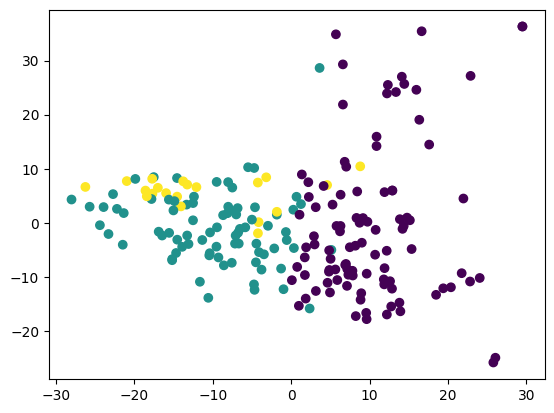

In [66]:
analyze_sense_clusters(llama_embeddings_data)

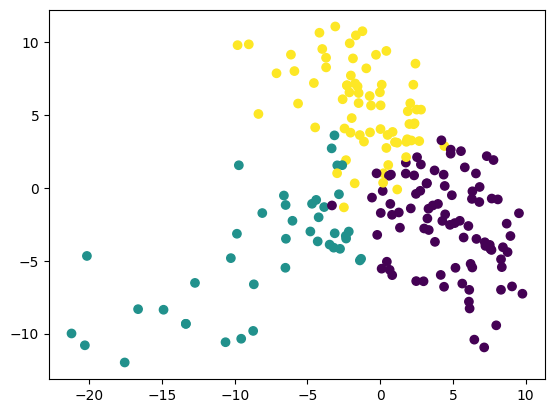

In [67]:
analyze_sense_clusters(phi_embeddings_data)

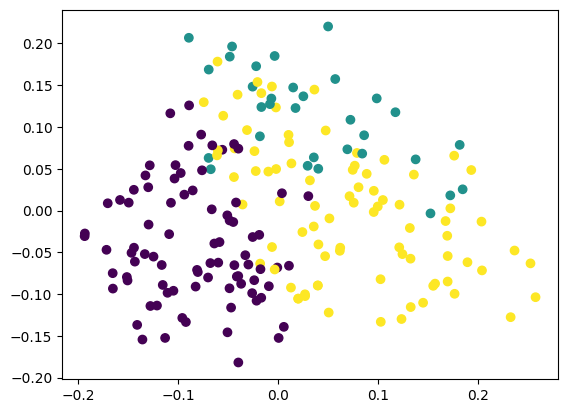

In [68]:
analyze_sense_clusters(gpt_embeddings_data)

In [66]:
def visualize_cosine_similarity(embeddings_data, Model=None):
    """ 
    Calculate cosine similarity between sentence embeddings and visualize the results 
    Cosine values range from -1 to 1, where 1 indicates identical vectors and -1 indicates opposite vectors.
    Similarity values close to 1 indicate that the sentences are similar, while values close to -1 indicate dissimilarity.
    """

    similarities = []
    for sample in embeddings_data:
        emb1, emb2 = sample['embeddings']
        similarity = cosine_similarity([emb1], [emb2])[0][0]
        similarities.append(similarity)
    
    labels = [sample['label'] for sample in embeddings_data]

    # Separate similarities into "same" and "different" based on labels
    same_similarities = [sim for sim, label in zip(similarities, labels) if label == 1]
    diff_similarities = [sim for sim, label in zip(similarities, labels) if label == 0]

    # Calculate statistics
    stats = {
        'same': {
            'min': np.min(same_similarities),
            'max': np.max(same_similarities),
            'mean': np.mean(same_similarities),
            'std': np.std(same_similarities),
        },
        'diff': {
            'min': np.min(diff_similarities),
            'max': np.max(diff_similarities),
            'mean': np.mean(diff_similarities),
            'std': np.std(diff_similarities),
        }
    }

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].scatter([0] * len(same_similarities), same_similarities, color='red', alpha=0.6, label='Same Sense')
    axs[0].scatter([1] * len(diff_similarities), diff_similarities, color='blue', alpha=0.6, label='Different Sense')
    axs[0].set_xticks([0, 1])
    axs[0].set_xticklabels(['Same Sense', 'Different Sense'])
    axs[0].set_xlabel('Label')
    axs[0].set_ylabel('Cosine Similarity')
    axs[0].set_title(f'Cosine Similarity Between Sentence Embeddings Model: {Model}')
    axs[0].legend()

    data = [same_similarities, diff_similarities]
    box = axs[1].boxplot(data, patch_artist=True, vert=True, showmeans=True, showfliers=False, widths=0.6)

    for i, label in enumerate(['Same Sense', 'Different Sense']):
        axs[1].text(i + 1, stats['same' if i == 0 else 'diff']['mean'] + 0.02, f"Mean: {stats['same' if i == 0 else 'diff']['mean']:.2f}\n"
                                               f"Std: {stats['same' if i == 0 else 'diff']['std']:.2f}",
                    color='black', fontsize=10, ha='center')

    axs[1].set_xticklabels(['Same Sense', 'Different Sense'])
    axs[1].set_title(f'Cosine Similarity Statistics Model: {Model}') 

    plt.tight_layout()
    plt.show()

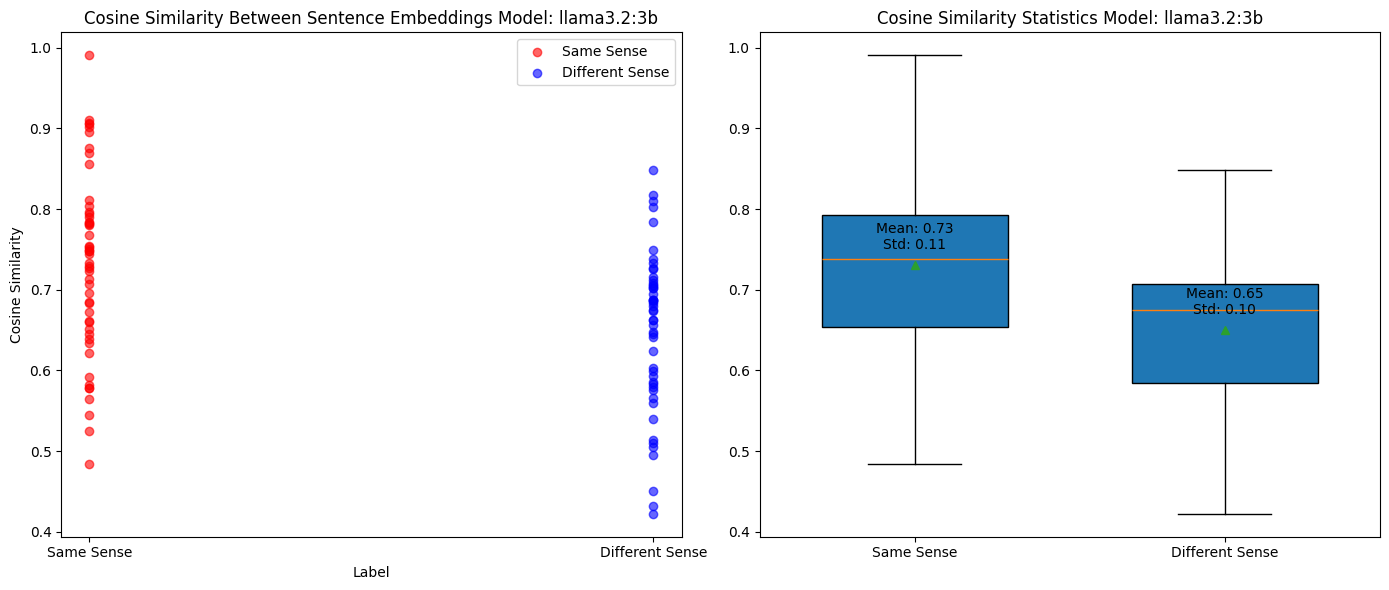

In [67]:
visualize_cosine_similarity(llama_embeddings_data, Model = MODEL_LLAMA3_2)

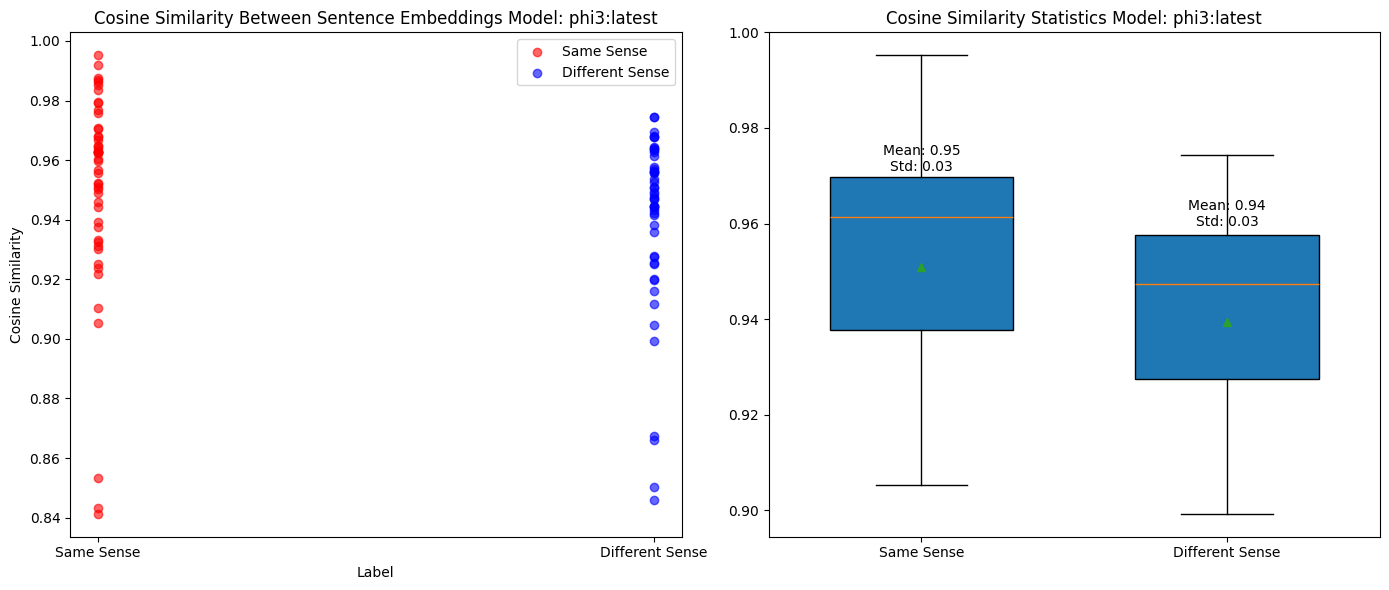

In [68]:
visualize_cosine_similarity(phi_embeddings_data, Model= MODEL_PHI3)

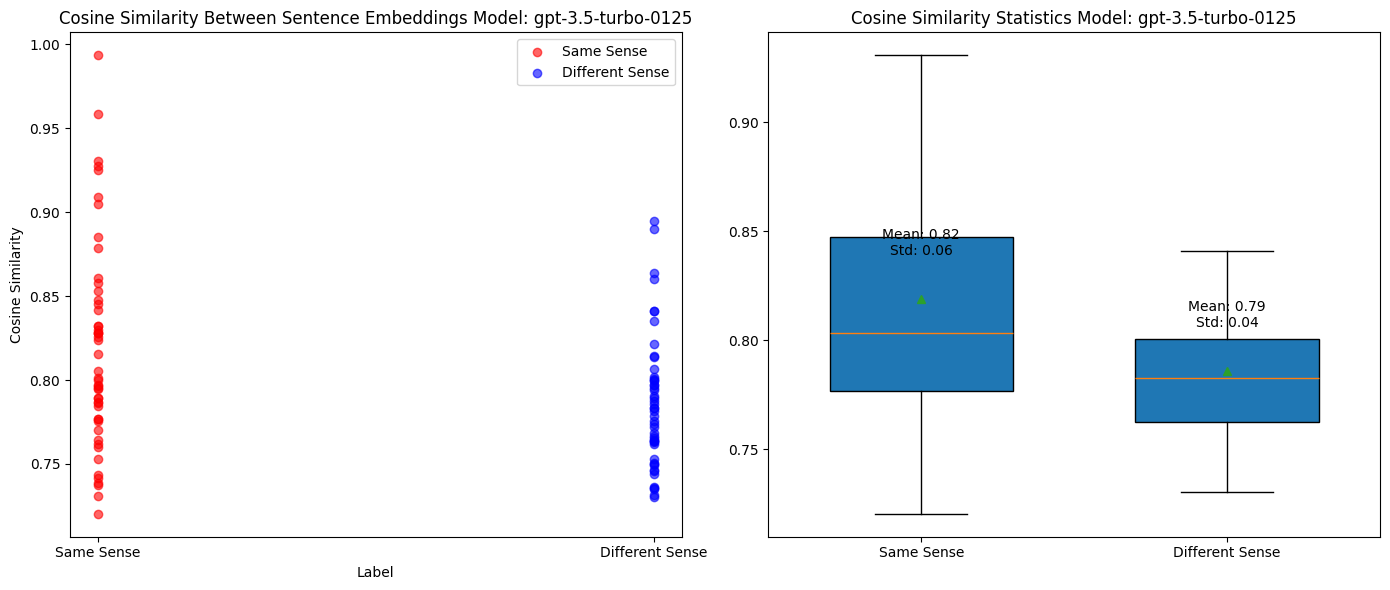

In [ ]:
visualize_cosine_similarity(gpt_embeddings_data, Model= MODEL_GPT3_5_TURBO)